 # Wildfire Susceptibility Machine Learning near the YKDelta of Alaska
 
 - This notebook demonstrates how to utilize using the XGBoost classification module to create Wildfire Susceptibility maps
 
 - Currently only Geospatial Data and Past Fire history is incorperated into the Machine Learning Module. Annual indices from a Netcdf file has been imported but not utilized so far
 
 - Currently the model works by training the XGboost on wildfire data from 2000 - 2019. This model is then used to create a fire susceptibility map for the year of 2020. This is then compared to the actual recorded fires of that year. The same elevation,slope and aspect values is used for every year. NDVI, Soil moisture, max avg monthly temp, and precipitation were all varied annually.
 
 - when training the module the wildfires are split from polygons to multiple point based entries. Consequently very large fires have a lot of data points. I believe this may lead to overfitting of the model however it does help with creating more datapoints as there is not a lot to begin with.
 
 ## Future Improvements
 - Incorperate the new data and remove some of the corresponding GIS data.
 
 - Create a more intuitive classification system for fires. You can seperate the fires into small medium, large and very large. This can potentially further help the model predict fires. This can also create a better predictability map and could potentially reduce the overfitting from all the point based entries from the same fire
 
 - Splitting the training and testing data in a more appropriate manner to prevent overfitting
 
 - There are certain sections of code where I have to iterate through the geopanda dataframe by row. Which is very slow. If these can be vectorized it will increase the speed of the program tremendously
 
 - Better susceptibility maps: currently to evaluate the model, hundreds of land points are created generated and the corresponding features are attached. The model outputs the probability of having a fire in that year which is how the susceptibility map is produced. A prettier and more intuitive graph could be made and there is probabily a faster way of generating all the points
 
 - incorperating monthy data instead of yearly data: (requires a large amount of data and need more detailed wildfire history)
 
 - predicting weather for the next year: in order to create the susceptibilty map for the year you need annual data. However, realistically you will not have that data when making the map. The model either needs to be trained on lagged features (data from the past to predict) or have another model to predict what the annual values will be.

  - shapley values analysis: The shapley module should be utilized to help interpret key features from the dataset. Helps make the model more interpretable
 
 
 - parameter hypertuning: I simply copied over the parameter hypertuning from the wildfire tutorial we utilized. However, it actually makes the prediction worse. A better method should be implemented
 

 

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import rasterize
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import box
from shapely import Point
import numpy as np
from math import ceil
import netCDF4 as nc
from sklearn.model_selection import RandomizedSearchCV

# Data imports

## Google Earth Engine TIFFS
 - all Earth Engine GeoTiffs are implemented using Rasterio 

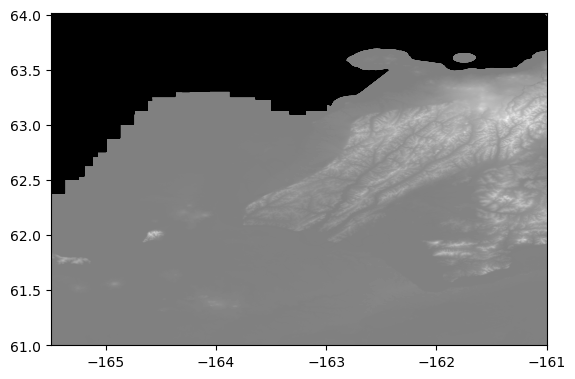

<Axes: >

In [2]:
#import YkDelta Elevation
Elev = rio.open("Data/elevation.tif")
show(Elev,cmap = 'gray',vmin=-1000,vmax=1000)

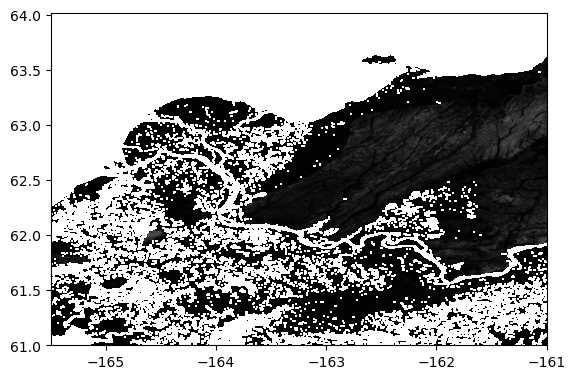

<Axes: >

In [3]:
#import YkDelta Slope
Slope = rio.open("Data/slope.tif")
show(Slope,cmap = 'gray',vmin=0,vmax=90)

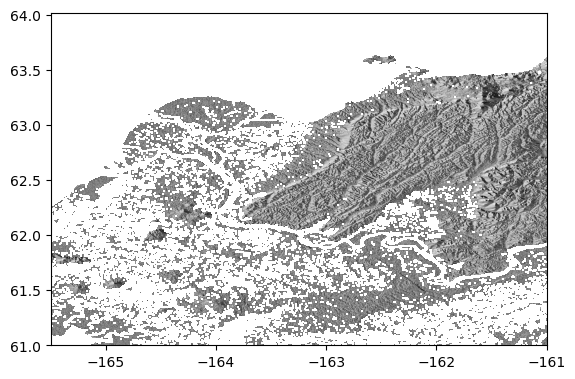

<Axes: >

In [4]:
#import YkDelta Aspect
Aspect = rio.open("Data/aspect.tif")
show(Aspect,cmap = 'gray',vmin=0,vmax=360)

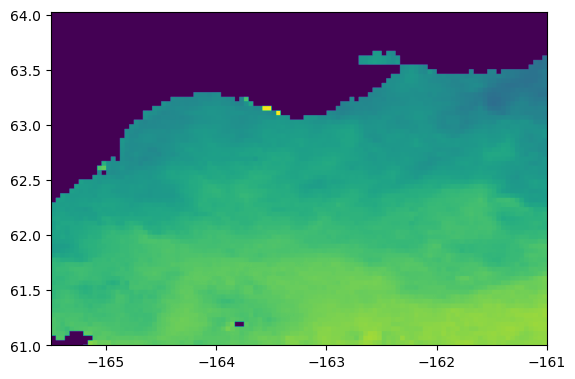

<Axes: >

In [5]:
#import YkDelta Average Max Monthly Temperature years 2000-2021 
max_avg_temp = []
for i in range(2000,2022,1):
    file_name = "Data/avg_maxtemp/avgmaxTemp_" + str(i) + ".tif"
    temp = rio.open(file_name) 
    max_avg_temp.append(temp)
show(temp)

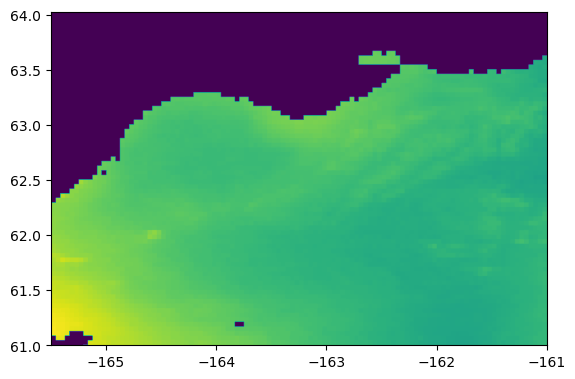

<Axes: >

In [6]:
#import Precipitation years 2000-2021 
precip = []
for i in range(2000,2022,1):
    file_name = "Data/precip/precip_" + str(i) + ".tif"
    pr = rio.open(file_name) 
    precip.append(pr)
show(pr)

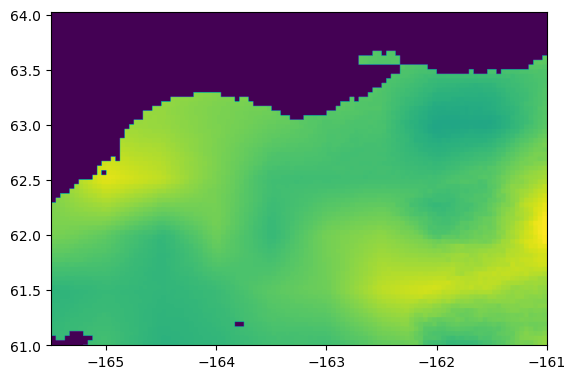

<Axes: >

In [7]:
#import Average Soil Moisture years 2000-2021 
soil = []
for i in range(2000,2022,1):
    file_name = "Data/soil/soil_" + str(i) + ".tif"
    sm = rio.open(file_name) 
    soil.append(sm)
show(sm)

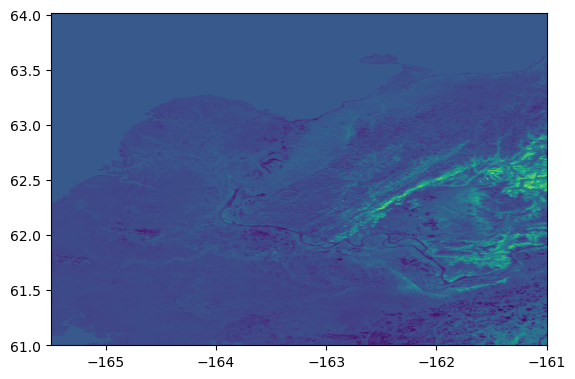

<Axes: >

In [8]:
# import NDVI years 2000-2021 
NDVI = []
for i in range(2000,2022,1):
    file_name = "Data/NDVI/NDVI_" + str(i) + ".tif"
    vi = rio.open(file_name) 
    NDVI.append(vi)
show(vi)

## Import NETCDF Data
- the annuall indices netcdf is imported here. However it is not utilized yet

In [9]:
ds = nc.Dataset("Data/annual_indices.nc")
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    creation_date: 2022-10-27T22:42:54Z
    dimensions(sizes): lon(153), lat(68), year(125), model(11), scenario(3)
    variables(dimensions): float64 lon(lon), float64 lat(lat), int64 year(year), <class 'str'> model(model), <class 'str'> scenario(scenario), float32 hsd(model, scenario, year, lat, lon), int32 wndd(model, scenario, year, lat, lon), float64 rx1day(model, scenario, year, lat, lon), float64 rx5day(model, scenario, year, lat, lon), int32 r10mm(model, scenario, year, lat, lon), int32 cwd(model, scenario, year, lat, lon), int32 cdd(model, scenario, year, lat, lon), float32 hd(model, scenario, year, lat, lon), int32 su(model, scenario, year, lat, lon), int32 wsdi(model, scenario, year, lat, lon), float32 cd(model, scenario, year, lat, lon), int32 dw(model, scenario, year, lat, lon), int32 csdi(model, scenario, year, lat, lon)
    groups: 

In [10]:
ds['r10mm']

<class 'netCDF4._netCDF4.Variable'>
int32 r10mm(model, scenario, year, lat, lon)
    _FillValue: -9999
    units: d
unlimited dimensions: 
current shape = (11, 3, 125, 68, 153)
filling on

In [11]:
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    _FillValue: nan
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (153,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    _FillValue: nan
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (68,)
filling on
<class 'netCDF4._netCDF4.Variable'>
int64 year(year)
unlimited dimensions: 
current shape = (125,)
filling on, default _FillValue of -9223372036854775806 used
<class 'netCDF4._netCDF4.Variable'>
vlen model(model)
vlen data type: <class 'str'>
unlimited dimensions: 
current shape = (11,)
<class 'netCDF4._netCDF4.Variable'>
vlen scenario(scenario)
vlen data type: <class 'str'>
unlimited dimensions: 
current shape = (3,)
<class 'netCDF4._netCDF4.Variable'>
float32 hsd(model, scenario, year, lat, lon)
    _FillValue: nan
    units: cm
unlimited dimensions: 
cu

## Wildfire History Import
- wildfire history Data is then imported as geopanda data frames

In [12]:
#import wildfire history
points_2020 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2020/AgecnyHistoricFirePerimeters_2020.shp')
points_2010 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2010_2019/AgencyHistoricFirePerimeters_2010_2019.shp')
points_2000 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2000_2009/AgencyHistoricFirePerimeters_2000_2009.shp')
#points_1990 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1990_1999/AgencyHistoricFirePerimeters_1990_1999.shp')
#points_1980 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1980_1989/AgencyHistoricFirePerimeters_1980_1989.shp')
#points_earlier = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1979_Earlier/AgencyHistoricFirePerimeters_1979_Earlier.shp')

The wildfire data from 2000 - 2019 are used to train the module and are combined

In [13]:
#combine all wildfire history
wildfire_points = gpd.GeoDataFrame(pd.concat([points_2010,points_2000],ignore_index = True))
#wildfire_points = gpd.GeoDataFrame(pd.concat([points_2020,points_2010,points_2000,points_1990,points_1980,points_earlier]))
wildfire_points

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
0,NaN,HART,2010,2010,CDF,CalFire FRAP,20100729,GPS Ground,3.321198,NaN,00005505,CASKU,NaN,Wildfire,NaN,5717,33873,5717,"POLYGON ((-122.33557 41.65648, -122.33557 41.6..."
1,NaN,HOLLOW,2010,2010,CDF,CalFire FRAP,20100726,GPS Ground,1.371385,NaN,00005373,CASKU,NaN,Wildfire,NaN,5718,33874,5718,"POLYGON ((-122.78650 41.60234, -122.78647 41.6..."
2,NaN,RY,2010,2010,CDF,CalFire FRAP,20100331,GPS Ground,7.196177,NaN,00002154,CASKU,NaN,Wildfire,NaN,5719,33875,5719,"POLYGON ((-122.47818 41.60885, -122.47818 41.6..."
3,NaN,WHISKEY,2010,2010,CDF,CalFire FRAP,20100623,GPS Ground,0.228372,NaN,00004299,CASKU,NaN,Wildfire,NaN,5720,33876,5720,"POLYGON ((-122.91199 41.44231, -122.91202 41.4..."
4,NaN,ANTELOPE,2010,2010,CDF,CalFire FRAP,20101026,GPS Ground,193.618256,NaN,00008386,CASLU,NaN,Wildfire,NaN,5721,33877,5721,"POLYGON ((-120.21049 35.73980, -120.21049 35.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46016,NaN,Montgomery,2009,2009,BLM,BLM,201802121157,Mixed Methods,289.935970,2009-CACDD-005602,5602,USCACDD,USCACDD,Wildfire,NaN,{552F6DF6-7918-4667-BAD5-D86373C4E81C},188418,107389,"POLYGON ((-115.37227 33.16523, -115.37225 33.1..."
46017,NaN,Midway,2009,2009,BLM,BLM,201802121157,Mixed Methods,111.609330,2009-CACDD-005989,5989,USCAPRI,USCACDD,Wildfire,NaN,{B98CD870-5605-4F53-A1B4-7A87B6D3E2ED},188441,107412,"MULTIPOLYGON (((-115.11094 32.70706, -115.1109..."
46018,NaN,Lamb,2009,2009,BLM,BLM,201802121157,Mixed Methods,288.135200,2009-CACDD-060763,60763,USCAPRI,USCARRU,Wildfire,NaN,{6C9222AA-930B-433F-A732-88E0FD05C5E7},188488,107456,"POLYGON ((-116.99752 33.86912, -116.99731 33.8..."
46019,NaN,Tram,2009,2009,BLM,BLM,201802121157,Mixed Methods,49.937878,2009-CACDD-005399,5399,USCAPRI,USCABDF,Wildfire,NaN,{D98C3BC8-9468-413E-ABEC-4AD540CCCC50},188503,107470,"POLYGON ((-116.55948 33.85561, -116.55950 33.8..."


# Isolating The YKDelta region from the Fire Data
- the fire data is for all of the United States, utilizing the elevation bounds, we will take only the fire points in the desired region

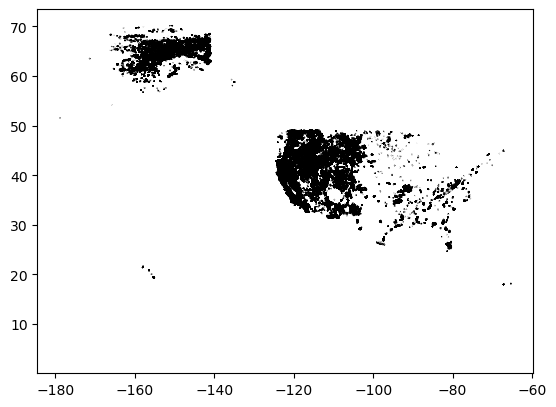

In [14]:
#plt.imshow(test_arr, cmap = 'gray')
f ,ax = plt.subplots()
tiff_extent = [Elev.bounds[0], Elev.bounds[2], Elev.bounds[1], Elev.bounds[3]]
#show(Elev.read(1),extent = tiff_extent, ax = ax )
#ax = plt.gca()
wildfire_points.plot(facecolor = 'w', edgecolor = 'k', ax = ax)#ax = plt.gca())
plt.show()

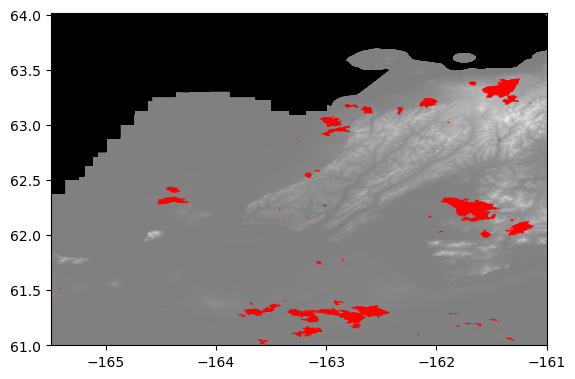

In [15]:
min_x = Elev.bounds[0]
max_x = Elev.bounds[2]
min_y = Elev.bounds[1]
max_y = Elev.bounds[3]

bbox = box(min_x, min_y, max_x, max_y)

wildfire_points_roi = wildfire_points[wildfire_points.geometry.within(bbox)].copy()
#test
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_roi.plot(ax = ax, color = 'r')
plt.gca().set_aspect('equal')

In [16]:
wildfire_points_roi = wildfire_points_roi.reset_index(drop = True)
wildfire_points_roi

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
0,{B3DBFAAC-4026-4467-B0D6-8235EAECFB1B},Kuyukutuk River,2019,2019,AICC,AFS,201906271400,Remote Sensing Derived,5083.531000,2019-AKGAD-000224,000224,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{1F397A0B-E191-41C0-8AA8-9B3C0E534CD0},376,77262,"POLYGON ((-161.51484 61.99549, -161.51576 61.9..."
1,{E183C4C0-3DE9-4723-8439-BAFAA90F14B2},Wolf Creek Mountain,2019,2019,AICC,AFS,201906271300,Remote Sensing Derived,673.669300,2019-AKGAD-000264,000264,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{B9F07799-6356-425B-AFF6-4CF24AAF1A26},378,77264,"POLYGON ((-161.61823 62.31926, -161.61737 62.3..."
2,{E716C424-6C2F-478E-97DB-1615C13DB78B},Takslesluk Lake,2019,2019,AICC,AFS,201906221410,Image Interpretation,178.848980,2019-AKSWS-000336,000336,NaN,AKSWS,Wildland Final Fire Perimeter,Photo rectified perimeter submitted by state f...,{B26A7B15-FAAA-47F3-B578-60383C1D737A},393,77279,"POLYGON ((-163.24514 61.13204, -163.24502 61.1..."
3,{3BD224B2-DA39-457E-ABE1-C26DC3E17A19},Gweek,2018,2018,AICC,AFS,201806131600,Image Interpretation,446.077820,2018-AKSWS-000181,000181,NaN,AKSWS,Wildland Final Fire Perimeter,Perimeter submitted by DOF-McGrath.,{96303B15-0A5A-4B0D-A8B9-C8AB4811EB35},486,77372,"POLYGON ((-161.85865 61.28825, -161.85775 61.2..."
4,{D408B745-AD1F-4F00-ADAF-5B438BF8EE8B},Kako Creek,2018,2018,AICC,AFS,201806091500,Image Interpretation,451.924700,2018-AKGAD-000172,000172,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{FD62124B-3C0F-414F-9CF0-17BF8F87E613},504,77390,"POLYGON ((-161.32757 62.13117, -161.32831 62.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,No IRWINID,Nageethluk River,2002,2002,AICC,AFS,200211011200,Digitized,657.620850,2002-AKGAD-000257,000257,NaN,AKGAD,Wildland Final Fire Perimeter,Modified perimeter from 2005 Landsat image (Ga...,{723475E4-FB72-4E29-82B0-74444E24A7BA},2362,79248,"POLYGON ((-161.75351 62.12688, -161.75343 62.1..."
111,No IRWINID,Pastolik River,2002,2002,AICC,AFS,20020616,None recorded,100.034096,2002-AKGAD-000301,000301,NaN,AKGAD,Wildland Final Fire Perimeter,None recorded,{6AD8B404-38A2-414C-9736-6D917DD49C19},2390,79276,"POLYGON ((-163.27248 62.88441, -163.27081 62.8..."
112,No IRWINID,Pastoliak River,2000,2000,AICC,AFS,200109211300,Image Interpretation,12127.565000,2000-AKGAD-00A383,00A383,NaN,AKGAD,Wildland Final Fire Perimeter,Fire perimeter modified using Landsat Image Se...,{C0A9FF51-B802-4E09-B1D6-6D5DEC485D3A},2420,79306,"POLYGON ((-162.80799 62.94848, -162.80772 62.9..."
113,NaN,Otter Creek,2008,2008,BLM,BLM,201711141331,Hand Sketch,48.160930,2008-AKADD-000305,305,USAKADD,USAKGAD,Wildfire,L. Sommer hand drawn.,{38EC81CA-8FC3-4E16-892C-8AF7C4F5A9AB},175990,99867,"POLYGON ((-161.15373 63.19420, -161.15370 63.1..."


# Wildfire Classification
## NOTE: This has been coded but not implemented 
- first we need to make sure the GIS ACRES category is filled for all the fires
- if they are not filled we will estimate them based on the ratio between the polygon area and the GIS acres of the existing ones
- Then the quartiles betwen all the fires will be determined (25% of the fires are small, 25% are medium, 25% are large and 25% are very large)
- based on these we classify small as 1, medium as 2, large as 3 and very large as 4

In [17]:
#find avaerage ration between Acres and area to determine typtical fire ratio
i = 0
area = 0 
for idx, fire in wildfire_points_roi.iterrows():
    if  not (pd.isna(fire['GIS_ACRES'])):
        #print(fire['GIS_ACRES']/fire.geometry.area)
        area = area + fire['GIS_ACRES']/fire.geometry.area
        i = i + 1
#print('average')
#print(area/i)
ratio = area/i

In [18]:
for idx, fire in wildfire_points_roi.iterrows():
    if pd.isna(fire['GIS_ACRES']):
        #print(fire.geometry.area)
        #print(fire.geometry.area * ratio)
        wildfire_points_roi.at[idx,'GIS_ACRES'] = (fire.geometry.area * ratio)
        
wildfire_points_roi['GIS_ACRES']    

0       5083.531000
1        673.669300
2        178.848980
3        446.077820
4        451.924700
           ...     
110      657.620850
111      100.034096
112    12127.565000
113       48.160930
114    57314.457000
Name: GIS_ACRES, Length: 115, dtype: float64

In [19]:
#if desire to split data into classifications of small. medium, large, extreme. Needs more data so going to skip for now
[first_quart, median, third_quart]= wildfire_points_roi['GIS_ACRES'].quantile([.25,.5,.75])
print(first_quart)
print(median)
print(third_quart)

356.17280000000005
953.94965
6989.632537314407


In [20]:
def fire_classify(value):
    if value < first_quart:
        return 1 #small fire
    elif value < median:
        return 2 #medium fire
    elif value < third_quart:
        return 3 #large fire
    else:
        return 4 #extrem fire

## All fires for now are classified as just 1

In [21]:
#wildfire_points_roi ['Fire_Classification'] = wildfire_points_roi['GIS_ACRES'].apply(fire_classify)
wildfire_points_roi['Fire_Classification'] = 1
wildfire_points_roi

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry,Fire_Classification
0,{B3DBFAAC-4026-4467-B0D6-8235EAECFB1B},Kuyukutuk River,2019,2019,AICC,AFS,201906271400,Remote Sensing Derived,5083.531000,2019-AKGAD-000224,000224,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{1F397A0B-E191-41C0-8AA8-9B3C0E534CD0},376,77262,"POLYGON ((-161.51484 61.99549, -161.51576 61.9...",1
1,{E183C4C0-3DE9-4723-8439-BAFAA90F14B2},Wolf Creek Mountain,2019,2019,AICC,AFS,201906271300,Remote Sensing Derived,673.669300,2019-AKGAD-000264,000264,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{B9F07799-6356-425B-AFF6-4CF24AAF1A26},378,77264,"POLYGON ((-161.61823 62.31926, -161.61737 62.3...",1
2,{E716C424-6C2F-478E-97DB-1615C13DB78B},Takslesluk Lake,2019,2019,AICC,AFS,201906221410,Image Interpretation,178.848980,2019-AKSWS-000336,000336,NaN,AKSWS,Wildland Final Fire Perimeter,Photo rectified perimeter submitted by state f...,{B26A7B15-FAAA-47F3-B578-60383C1D737A},393,77279,"POLYGON ((-163.24514 61.13204, -163.24502 61.1...",1
3,{3BD224B2-DA39-457E-ABE1-C26DC3E17A19},Gweek,2018,2018,AICC,AFS,201806131600,Image Interpretation,446.077820,2018-AKSWS-000181,000181,NaN,AKSWS,Wildland Final Fire Perimeter,Perimeter submitted by DOF-McGrath.,{96303B15-0A5A-4B0D-A8B9-C8AB4811EB35},486,77372,"POLYGON ((-161.85865 61.28825, -161.85775 61.2...",1
4,{D408B745-AD1F-4F00-ADAF-5B438BF8EE8B},Kako Creek,2018,2018,AICC,AFS,201806091500,Image Interpretation,451.924700,2018-AKGAD-000172,000172,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{FD62124B-3C0F-414F-9CF0-17BF8F87E613},504,77390,"POLYGON ((-161.32757 62.13117, -161.32831 62.1...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,No IRWINID,Nageethluk River,2002,2002,AICC,AFS,200211011200,Digitized,657.620850,2002-AKGAD-000257,000257,NaN,AKGAD,Wildland Final Fire Perimeter,Modified perimeter from 2005 Landsat image (Ga...,{723475E4-FB72-4E29-82B0-74444E24A7BA},2362,79248,"POLYGON ((-161.75351 62.12688, -161.75343 62.1...",1
111,No IRWINID,Pastolik River,2002,2002,AICC,AFS,20020616,None recorded,100.034096,2002-AKGAD-000301,000301,NaN,AKGAD,Wildland Final Fire Perimeter,None recorded,{6AD8B404-38A2-414C-9736-6D917DD49C19},2390,79276,"POLYGON ((-163.27248 62.88441, -163.27081 62.8...",1
112,No IRWINID,Pastoliak River,2000,2000,AICC,AFS,200109211300,Image Interpretation,12127.565000,2000-AKGAD-00A383,00A383,NaN,AKGAD,Wildland Final Fire Perimeter,Fire perimeter modified using Landsat Image Se...,{C0A9FF51-B802-4E09-B1D6-6D5DEC485D3A},2420,79306,"POLYGON ((-162.80799 62.94848, -162.80772 62.9...",1
113,NaN,Otter Creek,2008,2008,BLM,BLM,201711141331,Hand Sketch,48.160930,2008-AKADD-000305,305,USAKADD,USAKGAD,Wildfire,L. Sommer hand drawn.,{38EC81CA-8FC3-4E16-892C-8AF7C4F5A9AB},175990,99867,"POLYGON ((-161.15373 63.19420, -161.15370 63.1...",1


Drop all irrelevant columns

In [22]:
wildfire_points_roi = wildfire_points_roi[['FIRE_YEAR','Fire_Classification','geometry']]
wildfire_points_roi

,FIRE_YEAR,Fire_Classification,geometry
0,2019,1,"POLYGON ((-161.51484 61.99549, -161.51576 61.9..."
1,2019,1,"POLYGON ((-161.61823 62.31926, -161.61737 62.3..."
2,2019,1,"POLYGON ((-163.24514 61.13204, -163.24502 61.1..."
3,2018,1,"POLYGON ((-161.85865 61.28825, -161.85775 61.2..."
4,2018,1,"POLYGON ((-161.32757 62.13117, -161.32831 62.1..."
...,...,...,...
110,2002,1,"POLYGON ((-161.75351 62.12688, -161.75343 62.1..."
111,2002,1,"POLYGON ((-163.27248 62.88441, -163.27081 62.8..."
112,2000,1,"POLYGON ((-162.80799 62.94848, -162.80772 62.9..."
113,2008,1,"POLYGON ((-161.15373 63.19420, -161.15370 63.1..."


# Creating Wildfire points from the polygons

- first Display resolution to ensure the grid we pick for creating points is not smaller than the GeoTiff files being used

- then create a grid with uniform points with a proper resolution, this grid is then overlayed with the polygons to create numerous points for each fire

In [23]:
print("Elev Res: " + str(Elev.res))
print("Slope Res: " + str(Slope.res))
print("Aspect Res: " + str(Aspect.res))
print("NDVI Res: " + str(vi.res))
print("Precip Res: " + str(pr.res))
print("Temp Res: " + str(temp.res))
print("NDVI Res: " + str(sm.res))

Elev Res: (0.001167809869355378, 0.001167809869355378)
Slope Res: (0.001167809869355378, 0.001167809869355378)
Aspect Res: (0.001167809869355378, 0.001167809869355378)
NDVI Res: (0.0009881468125314736, 0.0009881468125314736)
Precip Res: (0.0016169675114151387, 0.0016169675114151387)
Temp Res: (0.0016169675114151387, 0.0016169675114151387)
NDVI Res: (0.0016169675114151387, 0.0016169675114151387)


In [24]:
x_spacing = .01
y_spacing = .01
xcoords = [i for i in np.arange(min_x,max_x, x_spacing)]
ycoords = [i for i in np.arange(min_y,max_y, y_spacing)]
pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1,2)
points = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
grid = gpd.GeoSeries(points, crs = wildfire_points_roi.crs)
grid.name = 'geometry'
#gridinside = gpd.sjoin(gpd.GeoDataFrame(grid), wildfire_points_roi[['geometry']], how = 'inner')
wildfire_point_data = gpd.overlay(gpd.GeoDataFrame(grid), wildfire_points_roi, how = 'intersection')

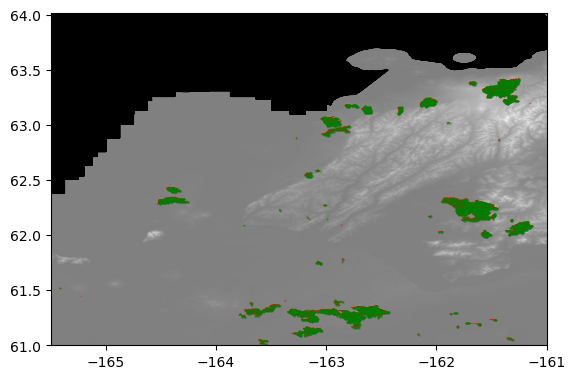

In [25]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_roi.plot(ax = ax, color = 'r')
#grid.plot(ax = ax, color = 'b', markersize = 1)
wildfire_point_data.plot(ax=ax, color = 'g', markersize = .1)
plt.gca().set_aspect('equal')

In [26]:
wildfire_point_data

,FIRE_YEAR,Fire_Classification,geometry
0,2002,1,POINT (-165.42085 61.51938)
1,2015,1,POINT (-164.52085 62.28938)
2,2015,1,POINT (-164.52085 62.29938)
3,2015,1,POINT (-164.52085 62.30938)
4,2015,1,POINT (-164.52085 62.31938)
...,...,...,...
4814,2017,1,POINT (-161.29085 63.40938)
4815,2017,1,POINT (-161.28085 63.39938)
4816,2017,1,POINT (-161.28085 63.40938)
4817,2017,1,POINT (-161.27085 63.39938)


# Add corresponding Features for each geographical point

- Here the spatial features are gathered from each geographical point
- sadly I iterated row by row here which makes this part run fairly slow

In [121]:
def extract_gis_value(geom:pd.Series,tiff)->pd.Series:

    x = geom.x
    y = geom.y
    px , py = tiff.index(x,y)
    value = tiff.read(1)[(px,py)]
    return value

def extract_gis_value_with_date(geom:pd.Series,year:pd.Series,tiff_arr)->pd.Series:
    x = geom.x
    y = geom.y
    year = year.astype(int).values
    year_indices = year- 2000    

    # Loop through the unique valid year indices
    values = []
    for year_index in np.unique(year_indices):
        image = tiff_arr[year_index]
        mask = year_indices == year_index
        px, py = image.index(x[mask], y[mask])
        value = image.read(1)[(px, py)]
        values.extend(value)
    return values

#for creating susceptibility map of 1 year
def extract_gis_value_with_single_date(geom:pd.Series,year:int,tiff_arr)->pd.Series:
    x = geom.x
    y = geom.y
    year_indices = year- 2000    
    px , py = tiff_arr[year_indices].index(x,y)
    value = tiff_arr[year.read(1)[(px,py)]
    return value

    

In [28]:
wildfire_point_data['Elevation'] = extract_gis_value(wildfire_point_data['geometry'],Elev)
wildfire_point_data['Slope'] = extract_gis_value(wildfire_point_data['geometry'],Slope)
wildfire_point_data['Aspect'] = extract_gis_value(wildfire_point_data['geometry'],Aspect)
wildfire_point_data['NDVI'] = extract_gis_value_with_date(wildfire_point_data['geometry'],wildfire_point_data['FIRE_YEAR'],NDVI)
wildfire_point_data['Soil_Moisture'] = extract_gis_value_with_date(wildfire_point_data['geometry'],wildfire_point_data['FIRE_YEAR'],soil)
wildfire_point_data['Max_Avg_Temp'] = extract_gis_value_with_date(wildfire_point_data['geometry'],wildfire_point_data['FIRE_YEAR'],max_avg_temp)
wildfire_point_data['Precipitation'] = extract_gis_value_with_date(wildfire_point_data['geometry'],wildfire_point_data['FIRE_YEAR'],precip)

In [34]:
#old version now vectorized keeping for reference
"""
Elevation_values = []
Slope_values = []
Aspect_values = []
NDVI_values = []
Soil_values = []
Temp_values = []
Precip_values = []

for index , row in wildfire_point_data.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    year_index = int(row.FIRE_YEAR) - 2000
    px, py = Elev.index(x,y)
    Elevation_values.append(Elev.read(1)[px,py])
    px , py = Slope.index(x,y)
    Slope_values.append(Slope.read(1)[px,py])
    px , py = Aspect.index(x,y)
    Aspect_values.append(Aspect.read(1)[px,py])
    px , py = NDVI[year_index].index(x,y)
    NDVI_values.append(NDVI[year_index].read(1)[px,py])
    px , py = soil[year_index].index(x,y)
    Soil_values.append(soil[year_index].read(1)[px,py])
    px , py = max_avg_temp[year_index].index(x,y)
    Temp_values.append(max_avg_temp[year_index].read(1)[px,py])
    px , py = precip[year_index].index(x,y)
    Precip_values.append(precip[year_index].read(1)[px,py])
    
    
""" 
    

In [35]:
"""
wildfire_point_data['Elevation'] = Elevation_values
wildfire_point_data['Slope'] = Slope_values
wildfire_point_data['Aspect'] = Aspect_values
wildfire_point_data['NDVI'] = NDVI_values
wildfire_point_data['Soil_Moisture'] = Soil_values
wildfire_point_data['Max_Avg_Temp'] = Temp_values
wildfire_point_data['Precipitation'] = Precip_values
"""

In [29]:
wildfire_point_data

,FIRE_YEAR,Fire_Classification,geometry,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,2002,1,POINT (-165.42085 61.51938),7.485719,0.516933,111.668938,504,579.583333,29.833333,619.0
1,2015,1,POINT (-164.52085 62.28938),12.468391,0.425506,191.000473,278,579.583333,29.833333,619.0
2,2015,1,POINT (-164.52085 62.29938),14.912006,0.542806,340.254883,237,573.750000,30.083333,622.0
3,2015,1,POINT (-164.52085 62.30938),14.805449,0.524709,168.474167,456,579.583333,29.833333,619.0
4,2015,1,POINT (-164.52085 62.31938),16.614864,0.687113,255.621719,141,573.750000,30.083333,622.0
...,...,...,...,...,...,...,...,...,...,...
4814,2017,1,POINT (-161.29085 63.40938),251.452209,1.623520,241.165115,148,579.666667,63.500000,599.0
4815,2017,1,POINT (-161.28085 63.39938),244.223221,1.746818,217.434738,1595,585.500000,63.083333,583.0
4816,2017,1,POINT (-161.28085 63.40938),262.031128,0.831312,255.087173,-255,579.666667,63.500000,599.0
4817,2017,1,POINT (-161.27085 63.39938),255.692963,0.904619,204.961624,1254,585.500000,63.083333,583.0


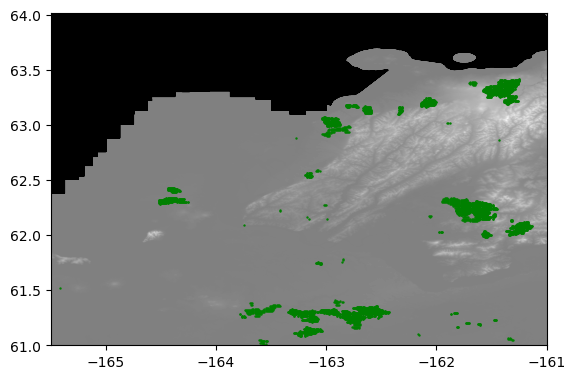

In [30]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
#wildfire_points_roi.plot(ax = ax, color = 'r')
#grid.plot(ax = ax, color = 'b', markersize = 1)
wildfire_point_data.plot(ax=ax, color = 'g', markersize = .5)
plt.gca().set_aspect('equal')

# Creating Non-fire Data points

For chosing non-fire examples there are a lot if different strategies one can engage.
- completely random:choose randomly between all non-firepoints on the map
- stratified: ensures selected points maintains distribution of dataset
- Spatial: ensure we sample all spatial regions
- Systematic: selecting points at regular intervals

For this example, an equal number of random points for each year will be selected

A uniform grid as used above is created; however now it is masked to the Elevation Tiff to only contain land points. From here a random amount of points are created each year that are not in that years fire polygos

In [31]:
num_per_year = ceil(len(wildfire_point_data)/21)
num_per_year

230

In [94]:
grid_land = []
def mask_to_land(point):
    px, py = Elev.index(point.x,point.y)
    point_elevation = Elev.read(1)[px-1,py]
    if point_elevation > 0:
        grid_land.append(point)

In [95]:
spacing = .05
xcoords = [i for i in np.arange(min_x+.05,max_x-.05, spacing)]
ycoords = [i for i in np.arange(min_y+.05,max_y-.05, spacing)]
pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1,2)
points = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
grid = gpd.GeoSeries(points, crs = wildfire_points_roi.crs)
grid.name = 'geometry'
grid_gdf = gpd.GeoDataFrame(grid)
"""
grid_land = []
for point in grid_gdf.geometry:
    px, py = Elev.index(point.x,point.y)
    point_elevation = Elev.read(1)[px-1,py]
    
    if point_elevation > 0:
        grid_land.append(point)
"""
grid_gdf.geometry.apply(mask_to_land)
land_gdf = gpd.GeoDataFrame(geometry=grid_land,  crs = wildfire_points_roi.crs)

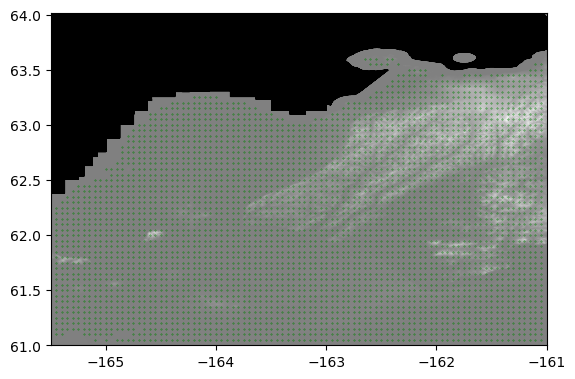

In [96]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
#wildfire_points_roi.plot(ax = ax, color = 'r')
land_gdf.plot(ax=ax, color = 'g', markersize = .1)
plt.gca().set_aspect('equal')

In [97]:
test = gpd.sjoin(land_gdf,wildfire_points_roi,how='left', predicate='within')
filtered_points = test[test.index_right.isna()]

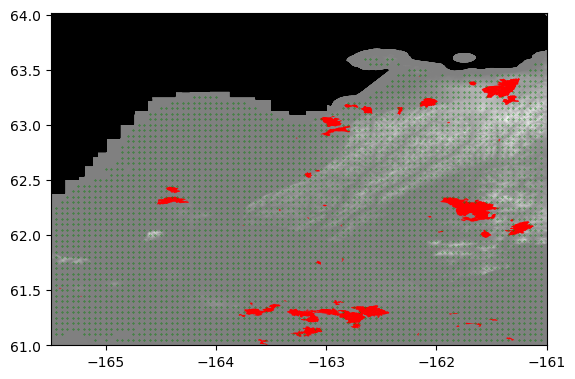

In [98]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_roi.plot(ax = ax, color = 'r')
filtered_points.plot(ax=ax, color = 'g', markersize = .1)
plt.gca().set_aspect('equal')

In [99]:
wildfire_points_roi

,FIRE_YEAR,Fire_Classification,geometry
0,2019,1,"POLYGON ((-161.51484 61.99549, -161.51576 61.9..."
1,2019,1,"POLYGON ((-161.61823 62.31926, -161.61737 62.3..."
2,2019,1,"POLYGON ((-163.24514 61.13204, -163.24502 61.1..."
3,2018,1,"POLYGON ((-161.85865 61.28825, -161.85775 61.2..."
4,2018,1,"POLYGON ((-161.32757 62.13117, -161.32831 62.1..."
...,...,...,...
110,2002,1,"POLYGON ((-161.75351 62.12688, -161.75343 62.1..."
111,2002,1,"POLYGON ((-163.27248 62.88441, -163.27081 62.8..."
112,2000,1,"POLYGON ((-162.80799 62.94848, -162.80772 62.9..."
113,2008,1,"POLYGON ((-161.15373 63.19420, -161.15370 63.1..."


In [100]:
non_fire_points = gpd.GeoDataFrame()
for i in range(2000,2021):
    shapes = wildfire_points_roi[wildfire_points_roi['FIRE_YEAR'] == str(i)]
    test = gpd.sjoin(land_gdf,shapes,how='left', predicate='within')
    filtered_points = test[test.index_right.isna()]
    random_points = filtered_points.sample(n=num_per_year, random_state = 42).geometry
    gdf = gpd.GeoDataFrame(random_points)
    gdf['FIRE_YEAR'] = str(i)
    #non_fire_points = non_fire_points.append(gdf)
    non_fire_points = gpd.GeoDataFrame(pd.concat([non_fire_points,gdf]))
    

Classify these as non-fire and give them a value of 0

In [101]:
non_fire_points['Fire_Classification'] = 0
non_fire_points

,geometry,FIRE_YEAR,Fire_Classification
1003,POINT (-164.10085 63.14938),2000,0
594,POINT (-164.55085 62.39938),2000,0
461,POINT (-164.70085 61.84938),2000,0
3021,POINT (-161.80085 61.24938),2000,0
3094,POINT (-161.75085 62.49938),2000,0
...,...,...,...
157,POINT (-165.15085 61.19938),2020,0
2727,POINT (-162.10085 61.09938),2020,0
3553,POINT (-161.30085 63.44938),2020,0
205,POINT (-165.10085 62.14938),2020,0


Adds corresponding Features for each point

In [102]:
non_fire_points['Elevation'] = extract_gis_value(non_fire_points['geometry'],Elev)
non_fire_points['Slope'] = extract_gis_value(non_fire_points['geometry'],Slope)
non_fire_points['Aspect'] = extract_gis_value(non_fire_points['geometry'],Aspect)
non_fire_points['NDVI'] = extract_gis_value_with_date(non_fire_points['geometry'],non_fire_points['FIRE_YEAR'],NDVI)
non_fire_points['Soil_Moisture'] = extract_gis_value_with_date(non_fire_points['geometry'],non_fire_points['FIRE_YEAR'],soil)
non_fire_points['Max_Avg_Temp'] = extract_gis_value_with_date(non_fire_points['geometry'],non_fire_points['FIRE_YEAR'],max_avg_temp)
non_fire_points['Precipitation'] = extract_gis_value_with_date(non_fire_points['geometry'],non_fire_points['FIRE_YEAR'],precip)
non_fire_points

,geometry,FIRE_YEAR,Fire_Classification,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
1003,POINT (-164.10085 63.14938),2000,0,2.410722,0.315734,230.921524,-447,649.000000,25.916667,634.0
594,POINT (-164.55085 62.39938),2000,0,1.974810,0.317318,261.795715,-386,693.000000,28.166667,714.0
461,POINT (-164.70085 61.84938),2000,0,3.557976,0.039286,239.140747,-518,557.000000,34.583333,769.0
3021,POINT (-161.80085 61.24938),2000,0,7.379329,0.154840,249.680450,-296,649.916667,44.750000,552.0
3094,POINT (-161.75085 62.49938),2000,0,80.089455,3.737676,328.968140,88,552.166667,34.583333,549.0
...,...,...,...,...,...,...,...,...,...,...
157,POINT (-165.15085 61.19938),2020,0,2.868213,0.088188,346.423950,-401,495.333333,38.416667,744.0
2727,POINT (-162.10085 61.09938),2020,0,5.831204,0.561945,274.436493,-723,498.583333,44.583333,514.0
3553,POINT (-161.30085 63.44938),2020,0,143.523468,2.732357,347.106140,-201,507.000000,27.916667,524.0
205,POINT (-165.10085 62.14938),2020,0,4.648583,1.049261,17.148584,-248,604.833333,33.916667,678.0


In [47]:
"""

Elevation_values = []
Slope_values = []
Aspect_values = []
NDVI_values = []
Soil_values = []
Temp_values = []
Precip_values = []

for index , row in non_fire_points.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    year_index = int(row.FIRE_YEAR) - 2000
    px, py = Elev.index(x,y)
    Elevation_values.append(Elev.read(1)[px-1,py])
    px , py = Slope.index(x,y)
    Slope_values.append(Slope.read(1)[px-1,py])
    px , py = Aspect.index(x,y)
    Aspect_values.append(Aspect.read(1)[px-1,py])
    px , py = NDVI[year_index].index(x,y)
    NDVI_values.append(NDVI[year_index].read(1)[px-1,py])
    px , py = soil[year_index].index(x,y)
    Soil_values.append(soil[year_index].read(1)[px-1,py])
    px , py = max_avg_temp[year_index].index(x,y)
    Temp_values.append(max_avg_temp[year_index].read(1)[px-1,py])
    px , py = precip[year_index].index(x,y)
    Precip_values.append(precip[year_index].read(1)[px-1,py])
"""

In [48]:
"""
non_fire_points['Elevation'] = Elevation_values
non_fire_points['Slope'] = Slope_values
non_fire_points['Aspect'] = Aspect_values
non_fire_points['NDVI'] = NDVI_values
non_fire_points['Soil_Moisture'] = Soil_values
non_fire_points['Max_Avg_Temp'] = Temp_values
non_fire_points['Precipitation'] = Precip_values
non_fire_points
"""

,geometry,FIRE_YEAR,Fire_Classification,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
149,POINT (-165.25085 62.39938),2000,0,2.459324,0.104219,192.017807,-518,679.000000,26.583333,743.0
1025,POINT (-164.10085 61.94938),2000,0,6.360659,0.110711,200.459137,-406,601.916667,35.583333,723.0
1288,POINT (-163.80085 61.44938),2000,0,30.163115,3.513069,169.632645,-471,567.833333,35.333333,746.0
720,POINT (-164.45085 62.49938),2000,0,4.937603,1.758992,100.755676,-474,715.000000,29.666667,699.0
325,POINT (-164.95085 62.24938),2000,0,2.422307,1.366352,309.317810,-385,684.000000,29.916667,745.0
...,...,...,...,...,...,...,...,...,...,...
2607,POINT (-162.35085 63.54938),2020,0,8.680375,7.334435,339.052887,-1353,497.583333,31.416667,532.0
3034,POINT (-161.90085 62.19938),2020,0,41.852787,0.352227,292.214661,-100,489.083333,37.000000,526.0
1510,POINT (-163.55085 61.49938),2020,0,8.833229,1.731466,72.038254,-480,553.833333,39.583333,681.0
3022,POINT (-161.90085 61.59938),2020,0,31.686539,3.768623,252.835037,1160,641.000000,39.166667,510.0


# Combining the data and preparing it for the module

In [103]:
total_data = gpd.GeoDataFrame(pd.concat([wildfire_point_data,non_fire_points], ignore_index = True))
total_data

,FIRE_YEAR,Fire_Classification,geometry,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,2002,1,POINT (-165.42085 61.51938),7.485719,0.516933,111.668938,504,579.583333,29.833333,619.0
1,2015,1,POINT (-164.52085 62.28938),12.468391,0.425506,191.000473,278,579.583333,29.833333,619.0
2,2015,1,POINT (-164.52085 62.29938),14.912006,0.542806,340.254883,237,573.750000,30.083333,622.0
3,2015,1,POINT (-164.52085 62.30938),14.805449,0.524709,168.474167,456,579.583333,29.833333,619.0
4,2015,1,POINT (-164.52085 62.31938),16.614864,0.687113,255.621719,141,573.750000,30.083333,622.0
...,...,...,...,...,...,...,...,...,...,...
9644,2020,0,POINT (-165.15085 61.19938),2.868213,0.088188,346.423950,-401,495.333333,38.416667,744.0
9645,2020,0,POINT (-162.10085 61.09938),5.831204,0.561945,274.436493,-723,498.583333,44.583333,514.0
9646,2020,0,POINT (-161.30085 63.44938),143.523468,2.732357,347.106140,-201,507.000000,27.916667,524.0
9647,2020,0,POINT (-165.10085 62.14938),4.648583,1.049261,17.148584,-248,604.833333,33.916667,678.0


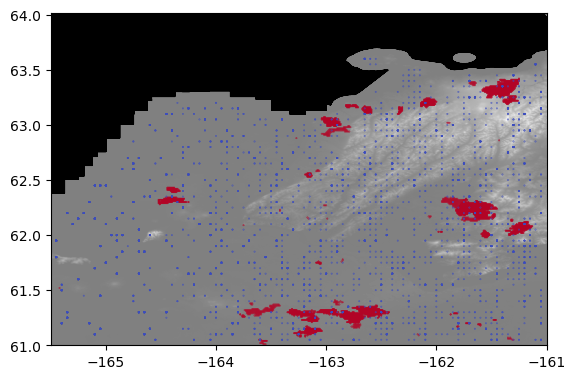

In [104]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
total_data.plot(ax = ax, column = 'Fire_Classification', cmap = 'coolwarm', markersize = .1)
plt.gca().set_aspect('equal')

In [105]:
X = total_data.drop(['geometry','FIRE_YEAR','Fire_Classification'], axis = 1)
X

,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,7.485719,0.516933,111.668938,504,579.583333,29.833333,619.0
1,12.468391,0.425506,191.000473,278,579.583333,29.833333,619.0
2,14.912006,0.542806,340.254883,237,573.750000,30.083333,622.0
3,14.805449,0.524709,168.474167,456,579.583333,29.833333,619.0
4,16.614864,0.687113,255.621719,141,573.750000,30.083333,622.0
...,...,...,...,...,...,...,...
9644,2.868213,0.088188,346.423950,-401,495.333333,38.416667,744.0
9645,5.831204,0.561945,274.436493,-723,498.583333,44.583333,514.0
9646,143.523468,2.732357,347.106140,-201,507.000000,27.916667,524.0
9647,4.648583,1.049261,17.148584,-248,604.833333,33.916667,678.0


In [106]:
y = total_data['Fire_Classification']
y

0       1
1       1
2       1
3       1
4       1
       ..
9644    0
9645    0
9646    0
9647    0
9648    0
Name: Fire_Classification, Length: 9649, dtype: int64

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=0)
X_train.shape, X_test.shape

((7236, 7), (2413, 7))

# Data Analysis

- use pearson correlation to check if any of the features are too correlated

- here shapley should be inserted

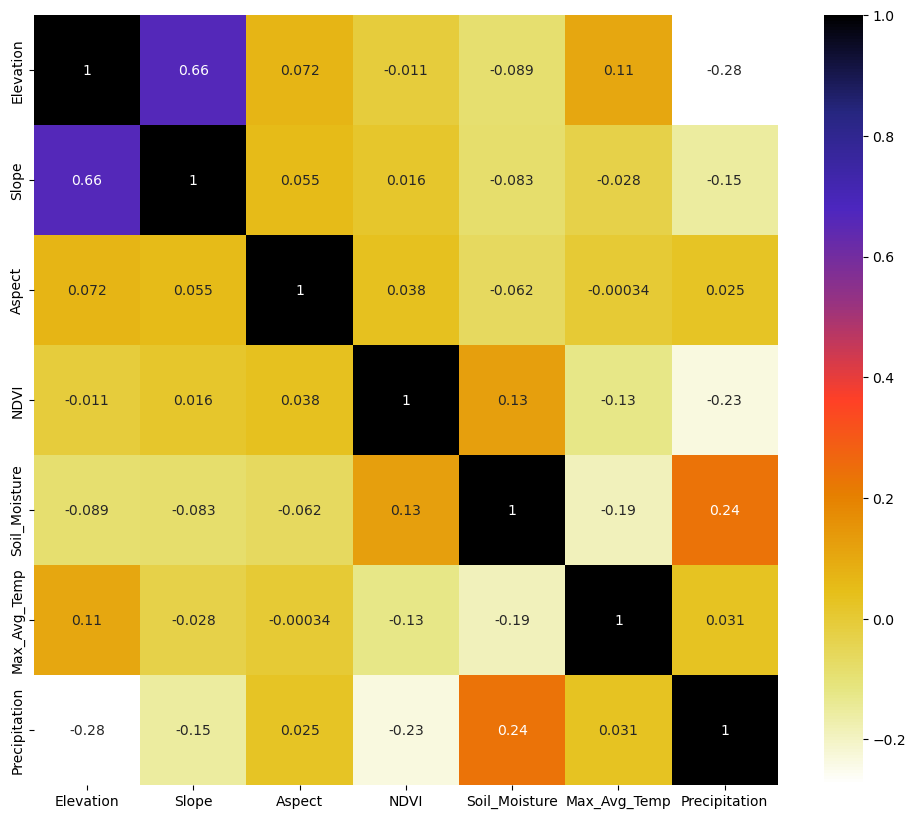

In [108]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

# XGBoost model

- here the model is trained and tested
- note that the model has a very high accuracy for both test and train
- this is because the fires are split randomly. We know that there are multiple points for each fire. Thus, if the model gets trained on a point and then tested on a seperate point for that same fire it will likely be extremely accurate.
- a better way of splitting the data needs to be incorperated (this could be done by training on all of the data from above and just testing it on the 2020)

In [109]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [110]:
print("Training Score: ", xgb.score(X_train,y_train))
print("Test Score: ", xgb.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.9834231247409864


In [111]:
xgb_predic = xgb.predict(X_test)
Score = accuracy_score(y_test, xgb_predic)
Classification_Report = classification_report(y_test, xgb_predic)

print("XGboost Classifier")
print("Accuracy Score value: {:.4f}".format(Score))
print(Classification_Report)


XGboost Classifier
Accuracy Score value: 0.9834
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1226
           1       0.98      0.98      0.98      1187

    accuracy                           0.98      2413
   macro avg       0.98      0.98      0.98      2413
weighted avg       0.98      0.98      0.98      2413



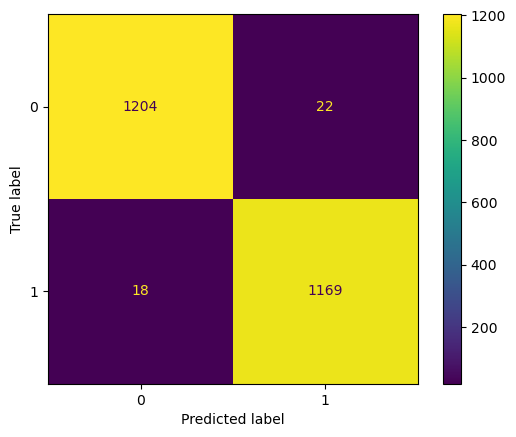

In [112]:
xgb_cm = ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

# Hyperparemter tuning

- this needs work, simply taken from tutorial (the tuned model performs worse)
- incorperatin a genetic aglorithm or some metahueristic algorithm I believe will give the best results

In [113]:
params={
 "learning_rate"    : (np.linspace(0,10, 100)) ,
 "max_depth"        : (np.linspace(1,50, 25,dtype=int)),
 "min_child_weight" : [1, 3, 5, 7],
 "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
 "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}
Random_xgb = RandomizedSearchCV(xgb, params, cv = 10,n_jobs = -1)
Random_xgb.fit(X_train, y_train).best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.8181818181818181,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=27, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [114]:
Best_xgb = Random_xgb.best_estimator_
Best_xgb.score(X_test,y_test)

0.9763779527559056

In [115]:
Bestxgb_prediction = Best_xgb.predict(X_test)
Bestxgb_prediction

array([0, 1, 1, ..., 1, 1, 1])

In [116]:
Score = accuracy_score(y_test, Bestxgb_prediction)
Classification_Report = classification_report(y_test,Bestxgb_prediction)
print("FINAL XGB")
print ("Accuracy Score value: {:.4f}".format(Score))
print (Classification_Report)

FINAL XGB
Accuracy Score value: 0.9764
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1226
           1       0.98      0.97      0.98      1187

    accuracy                           0.98      2413
   macro avg       0.98      0.98      0.98      2413
weighted avg       0.98      0.98      0.98      2413



In [117]:
xgb.predict_proba(X_test)

array([[9.9969721e-01, 3.0279061e-04],
       [4.7004223e-03, 9.9529958e-01],
       [4.0763617e-04, 9.9959236e-01],
       ...,
       [3.7795901e-03, 9.9622041e-01],
       [5.6593418e-03, 9.9434066e-01],
       [5.5688620e-04, 9.9944311e-01]], dtype=float32)

# Creating a susceptibility Map for the year of 2020
- the land grid used earlier will now be used to predict fires
- each 

In [118]:
susceptibility_input = land_gdf.copy()

In [122]:
susceptibility_input['Elevation'] = extract_gis_value(susceptibility_input['geometry'],Elev)
susceptibility_input['Slope'] = extract_gis_value(susceptibility_input['geometry'],Slope)
susceptibility_input['Aspect'] = extract_gis_value(susceptibility_input['geometry'],Aspect)
susceptibility_input['NDVI'] = extract_gis_value_with_single_date(susceptibility_input['geometry'],2020,NDVI)
susceptibility_input['Soil_Moisture'] = extract_gis_value_with_single_date(susceptibility_input['geometry'],2020,soil)
susceptibility_input['Max_Avg_Temp'] = extract_gis_value_with_single_date(susceptibility_input['geometry'],2020,max_avg_temp)
susceptibility_input['Precipitation'] = extract_gis_value_with_single_date(susceptibility_input['geometry'],2020,precip)
susceptibility_input

NameError: name 'tiff' is not defined

In [65]:
Elevation_values = []
Slope_values = []
Aspect_values = []
NDVI_values = []
Soil_values = []
Temp_values = []
Precip_values = []

for index , row in susceptibility_input.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    year_index = 2020 - 2000
    px, py = Elev.index(x,y)
    Elevation_values.append(Elev.read(1)[px-1,py])
    px , py = Slope.index(x,y)
    Slope_values.append(Slope.read(1)[px-1,py])
    px , py = Aspect.index(x,y)
    Aspect_values.append(Aspect.read(1)[px-1,py])
    px , py = NDVI[year_index].index(x,y)
    NDVI_values.append(NDVI[year_index].read(1)[px-1,py])
    px , py = soil[year_index].index(x,y)
    Soil_values.append(soil[year_index].read(1)[px-1,py])
    px , py = max_avg_temp[year_index].index(x,y)
    Temp_values.append(max_avg_temp[year_index].read(1)[px-1,py])
    px , py = precip[year_index].index(x,y)
    Precip_values.append(precip[year_index].read(1)[px-1,py])

In [66]:
susceptibility_input['Elevation'] = Elevation_values
susceptibility_input['Slope'] = Slope_values
susceptibility_input['Aspect'] = Aspect_values
susceptibility_input['NDVI'] = NDVI_values
susceptibility_input['Soil_Moisture'] = Soil_values
susceptibility_input['Max_Avg_Temp'] = Temp_values
susceptibility_input['Precipitation'] = Precip_values
susceptibility_input

,geometry,Elevation,Slope,Aspect,NDVI,Soil_Moisture,Max_Avg_Temp,Precipitation
0,POINT (-165.50085 61.09938),3.169078,0.155076,155.983749,-1840,470.166667,40.166667,737.0
1,POINT (-165.50085 61.14938),3.118368,0.488147,75.755875,496,470.750000,39.833333,739.0
2,POINT (-165.50085 61.19938),2.728455,0.062791,21.831240,282,472.333333,39.416667,738.0
3,POINT (-165.50085 61.24938),2.959280,0.240088,277.270294,783,473.000000,38.333333,730.0
4,POINT (-165.50085 61.29938),2.622793,0.071229,13.524855,250,473.333333,37.666667,726.0
...,...,...,...,...,...,...,...,...
3959,POINT (-161.00085 63.39938),156.144440,14.351768,332.277161,-117,554.500000,27.000000,503.0
3960,POINT (-161.00085 63.44938),166.999756,3.755075,340.756165,-32,551.250000,27.250000,503.0
3961,POINT (-161.00085 63.49938),156.060791,2.488608,221.806946,-106,545.250000,26.666667,496.0
3962,POINT (-161.00085 63.54938),106.984833,1.438077,327.994690,-177,547.166667,26.666667,482.0


In [67]:
susceptibility_input_for_model = susceptibility_input.drop(['geometry'], axis = 1)
susceptibility_output = xgb.predict_proba(susceptibility_input_for_model)
susceptibility_output

array([[9.99916375e-01, 8.36044783e-05],
       [9.99758422e-01, 2.41570684e-04],
       [9.99631703e-01, 3.68277193e-04],
       ...,
       [8.94881785e-01, 1.05118208e-01],
       [9.89049375e-01, 1.09506082e-02],
       [9.87683773e-01, 1.23162465e-02]], dtype=float32)

In [68]:
susceptibility_map = susceptibility_input[['geometry']].copy()
susceptibility_map['fire_risk'] = susceptibility_output[:,1]
susceptibility_map

,geometry,fire_risk
0,POINT (-165.50085 61.09938),0.000084
1,POINT (-165.50085 61.14938),0.000242
2,POINT (-165.50085 61.19938),0.000368
3,POINT (-165.50085 61.24938),0.000396
4,POINT (-165.50085 61.29938),0.000335
...,...,...
3959,POINT (-161.00085 63.39938),0.029595
3960,POINT (-161.00085 63.44938),0.019224
3961,POINT (-161.00085 63.49938),0.105118
3962,POINT (-161.00085 63.54938),0.010951


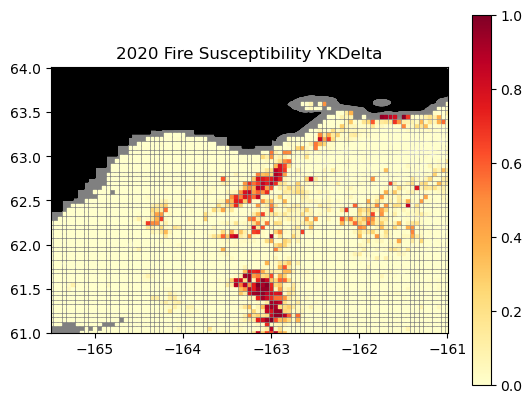

In [69]:
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
susceptibility_map.plot(ax = ax, column = 'fire_risk', cmap = 'YlOrRd',\
                        markersize = 4, vmin = 0, vmax = 1, legend = True, marker = 's')
plt.title("2020 Fire Susceptibility YKDelta")
plt.gca().set_aspect('equal')

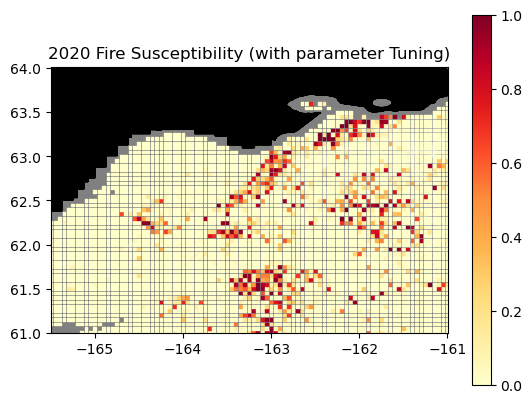

In [70]:
susceptibility_output_tuned = Best_xgb.predict_proba(susceptibility_input_for_model)
susceptibility_map_tuned = susceptibility_input[['geometry']].copy()
susceptibility_map_tuned['fire_risk'] = susceptibility_output_tuned[:,1]

f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
susceptibility_map_tuned.plot(ax = ax, column = 'fire_risk', cmap = 'YlOrRd',\
                        markersize = 4, vmin = 0, vmax = 1, legend = True, marker = 's')
plt.title("2020 Fire Susceptibility (with parameter Tuning)")
plt.gca().set_aspect('equal')

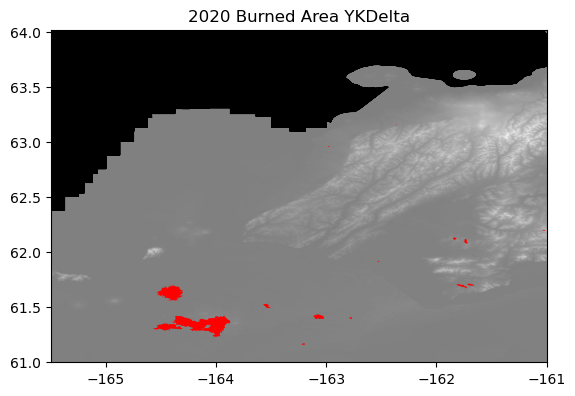

In [71]:
wildfire_points_2020_roi = points_2020[points_2020.geometry.within(bbox)].copy()
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_2020_roi.plot(ax = ax, color = 'r')
plt.title("2020 Burned Area YKDelta")
plt.gca().set_aspect('equal')

In [72]:
wildfire_points_2020_roi

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
1163,{38D60820-0B14-4D78-85E7-6B7FE8CD6847},Kgun Lake,2020,2020,AICC,AFS,202008021400,Image Interpretation,1523.284400,2020-AKSWS-000347,000347,NaN,AKSWS,Wildland Final Fire Perimeter,Perimeter updated by AFS (D. Griggs) using Sen...,{BF517FA8-5939-4426-AD85-5302EF34EBF8},5,76891,"POLYGON ((-163.54461 61.49434, -163.54526 61.4..."
1169,{86E9E21E-D3E9-462B-BD6D-7D846AE0D570},Ingakslugwat Hills,2020,2020,AICC,AFS,202007131400,Image Interpretation,54099.105000,2020-AKSWS-000116,000116,NaN,AKSWS,Wildland Final Fire Perimeter,Perimeter updated by DOF-MSS (Snyder) using Se...,{6992C175-8A1D-4144-8E9C-B9D411D588EB},11,76897,"MULTIPOLYGON (((-164.06391 61.34012, -164.0638..."
1191,{9F92243A-F3AB-4466-8277-3F9CC0DABCEB},Imik Lagoon,2020,2020,AICC,AFS,202006211615,Image Interpretation,249.126130,2020-AKSWS-000266,000266,NaN,AKSWS,Wildland Final Fire Perimeter,Photo-rectification perimeter submitted by DOF...,{FB53C8FC-5EF3-435D-AB70-F24C13E9E43B},33,76919,"POLYGON ((-163.20874 61.16151, -163.20847 61.1..."
1206,{1A22F30B-799A-46A0-9249-DB2734E2F4AE},Pastoliak River,2020,2020,AICC,AFS,202006181400,Image Interpretation,59.288490,2020-AKGAD-000280,000280,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{A7D7E4E5-19DB-4B48-926F-DB6446D2A0A5},48,76934,"POLYGON ((-162.98149 62.95970, -162.98108 62.9..."
1212,{82538A94-A86F-4B84-A036-16C5A0EA210F},Engineer Lake,2020,2020,AICC,AFS,202006181400,Image Interpretation,1010.045000,2020-AKGAD-000141,000141,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Sentinel 2 image colle...,{93004785-277D-4D70-A375-6BF255942FBB},54,76940,"POLYGON ((-161.71299 61.71402, -161.71279 61.7..."
1221,{89A1054D-105F-4085-9147-31B95AE5CC2F},Manokinak River,2020,2020,AICC,AFS,202006161400,Image Interpretation,12133.260000,2020-AKSWS-000118,000118,NaN,AKSWS,Wildland Final Fire Perimeter,Perimeter updated by DOF-WSW (Snyder) using Se...,{1F66A54D-3A4A-4B7E-B75E-FD788F47D440},63,76949,"POLYGON ((-164.45483 61.34810, -164.45429 61.3..."
1233,{00855C99-76A3-4FED-98AA-9DB811182733},Kochilagok Hill,2020,2020,AICC,AFS,202006142100,Image Interpretation,29322.188000,2020-AKSWS-000153,000153,NaN,AKSWS,Wildland Final Fire Perimeter,Submitted by State Forestry.,{682E08C4-33E7-4CEC-A501-A2DFF82D1497},75,76961,"POLYGON ((-164.31150 61.60518, -164.31046 61.6..."
1247,{0D40DBCC-5EBA-4B37-93EE-AA81690D69F7},Hawk River,2020,2020,AICC,AFS,202006111400,Image Interpretation,220.589190,2020-AKGAD-000132,000132,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Sentinel 2 image colle...,{53DA211B-2DA6-4D79-8D2D-66F6D3B2E91C},89,76975,"POLYGON ((-161.03414 62.19960, -161.03323 62.1..."
1250,{F4A8A1AB-1BE4-4C8D-8E17-875937348B4A},Iwaktok Hill,2020,2020,AICC,AFS,202006091640,Image Interpretation,13030.349000,2020-AKSWS-000154,000154,NaN,AKSWS,Wildland Final Fire Perimeter,Perimeter updated using photorectified images ...,{31230CCF-B535-45EB-BD63-EB3309DE518B},92,76978,"POLYGON ((-164.34817 61.41872, -164.34762 61.4..."
1252,{EBFDCE64-9D04-4DB5-B243-5D5ADB13751D},Engineer Lake 2,2020,2020,AICC,AFS,202006091400,Image Interpretation,1801.089000,2020-AKGAD-000142,000142,NaN,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Sentinel 2 image colle...,{49CCDD8D-0DF2-48EE-BA2D-5BD7D707DB1E},94,76980,"POLYGON ((-161.79741 61.70941, -161.79683 61.7..."
